# Patch Fitting

# Helpers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import skimage
import skimage.measure
import nibabel as nib
from skimage.transform import resize
from include import *
import cv2
import csv
import itertools

import json
import time
import os

from piq import ssim, vif_p, multi_scale_ssim, psnr

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("num GPUs",torch.cuda.device_count())
#dtype = torch.FloatTensor

def tensor_to_image(tensor):
    """ (c,w,h) -> (w,h,c) """
    image = np.transpose(tensor.numpy(), (1, 2, 0))
    return image


def image_to_tensor(image):
    """ (w,h,c) -> (c,w,h) """
    tensor = torch.from_numpy(np.transpose(image, (2, 0, 1)))
    return tensor


def load_image(image_path):
    """ Load image and normalize to [0,1]. Add 3rd dimension if original is black and white."""
    original_image = skimage.io.imread(image_path)
    original_image = original_image.astype(float) / 255
    if len(original_image.shape) == 2:
        original_image = original_image[:, :, None]
    return original_image


def extract_MRI_slice(volume_path):

    # Load the MRI volume
    volume = nib.load(volume_path)

    # Get the data array from the volume
    data = volume.get_fdata()

    # Get a slice from the middle of the volume
    
    z = data.shape[-1] // 2
    sliced = data[..., z]
    
    # Normalize to [0,1]. Add 3rd dimension if original is black and white
    
    sliced = sliced.astype(float)
    sliced = (sliced - np.min(sliced)) / (np.max(sliced) - np.min(sliced))
    if len(sliced.shape) == 2:
        sliced = sliced[:, :, None]
        
    return sliced


def crop_center(image, crop_size):
    """
    Crop the center of an image to a square with the specified size.
    If the input image is smaller than the desired output size, it is padded with zeros.
    
    Parameters
    ----------
    image : numpy.ndarray
        The input image as a NumPy array.
        Should have shape (height, width, channels).
    crop_size : int
        The desired output size (in pixels) of the square image.
    
    Returns
    -------
    numpy.ndarray
        The center-cropped image as a NumPy array.
        Has shape (crop_size, crop_size, channels).
    """
    # Calculate the center coordinates of the image
    y_center = image.shape[0] // 2
    x_center = image.shape[1] // 2
    
    # Calculate the start and end coordinates for the cropping
    x_start = max(x_center - crop_size // 2, 0)
    x_end = min(x_center + crop_size // 2, image.shape[1])
    y_start = max(y_center - crop_size // 2, 0)
    y_end = min(y_center + crop_size // 2, image.shape[0])
    
    # Crop the image and pad with zeros if necessary
    cropped_image = np.zeros((crop_size, crop_size, image.shape[2]), dtype=image.dtype)
    cropped_image[(crop_size - (y_end - y_start)) // 2:(crop_size - (y_end - y_start)) // 2 + (y_end - y_start),
                  (crop_size - (x_end - x_start)) // 2:(crop_size - (x_end - x_start)) // 2 + (x_end - x_start),
                  :] = image[y_start:y_end, x_start:x_end, :]
    
    # Return the result
    return cropped_image

'''
def divide_into_patches(image, patch_size):
    num_rows = image.shape[0] // patch_size
    num_cols = image.shape[1] // patch_size
    patches = {}
    for r in range(num_rows):
        for c in range(num_cols):
            patch = image[r*patch_size:(r+1)*patch_size, c*patch_size:(c+1)*patch_size]
            patches[(r, c)] = patch
    return patches
'''

import numpy as np

def divide_into_patches(image, patch_size):
    image_height, image_width = image.shape[:2]
    patch_height, patch_width = patch_size

    if image_height % patch_height != 0 or image_width % patch_width != 0:
        print("Warning: The patches may leave out part of the image.")

    num_rows = image_height // patch_height
    num_cols = image_width // patch_width
    patches = {}
    for r in range(num_rows):
        for c in range(num_cols):
            patch = image[r*patch_height:(r+1)*patch_height, c*patch_width:(c+1)*patch_width]
            patches[(r, c)] = patch
    return patches

'''
def merge_patches(patches):
    # get the patch size and number of channels
    patch_size = patches[(0, 0)].shape[0]
    num_channels = patches[(0, 0)].shape[-1] if len(patches[(0, 0)].shape) > 2 else 1

    # calculate the size of the output image
    num_rows = max([key[0] for key in patches.keys()]) + 1
    num_cols = max([key[1] for key in patches.keys()]) + 1
    output_shape = (num_rows * patch_size, num_cols * patch_size, num_channels)

    # create an empty output image
    output_image = np.zeros(output_shape)

    # iterate over the patches and place them in the output image
    for key, patch in patches.items():
        row, col = key
        output_image[row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = patch

    return output_image
'''
import numpy as np

def merge_patches(patches):
    # get the patch size and number of channels
    patch_size = patches[(0, 0)].shape[:2]
    num_channels = patches[(0, 0)].shape[-1] if len(patches[(0, 0)].shape) > 2 else 1

    # calculate the size of the output image
    num_rows = max([key[0] for key in patches.keys()]) + 1
    num_cols = max([key[1] for key in patches.keys()]) + 1
    output_shape = (num_rows * patch_size[0], num_cols * patch_size[1], num_channels)

    # create an empty output image
    output_image = np.zeros(output_shape)

    # iterate over the patches and place them in the output image
    for key, patch in patches.items():
        row, col = key
        output_image[row*patch_size[0]:(row+1)*patch_size[0], col*patch_size[1]:(col+1)*patch_size[1]] = patch

    return output_image

def save_dictionary_to_json(dictionary, filename):
    processed_dict = {
        str(key): value.tolist() if isinstance(value, np.ndarray) else value
        for key, value in dictionary.items()
    }
    with open(filename, "w") as file:
        json.dump(processed_dict, file)
        
def load_dictionary_from_json(filename):
    with open(filename, "r") as file:
        loaded_dict = json.load(file)

    recovered_dict = {}
    for key_str, value in loaded_dict.items():
        key_tuple = ast.literal_eval(key_str)
        if isinstance(value, list):
            value = np.array(value)
        recovered_dict[key_tuple] = value

    return recovered_dict

def rep_error_deep_decoder(img_np,k=128,convert2ycbcr=False):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    
    output_depth = img_np.shape[0]
    if output_depth == 3 and convert2ycbcr:
        img = rgb2ycbcr(img_np)
    else:
        img = img_np
    
    #CAUTION
    img_var = np_to_var(img).type(dtype)
    
    #img_var = img
    
    num_channels = [k]*5
    print(num_channels)
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)
    rnd = 500
    numit = 20000
    rn = 0.005
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.005,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                               )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    if output_depth == 3 and convert2ycbcr:
        out_img = ycbcr2rgb(out_img)
    return psnr(out_img,img_np), out_img, num_param(net)

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')

def comparison(img_np, k, convert2ycbcr=False):
    # compute representations
    psnrv, out_img_np, nparms = rep_error_deep_decoder(img_np, k=k, convert2ycbcr=convert2ycbcr)
    
    print("Compression factor: ", np.prod(img_np.shape) / nparms)
    
    # plot results
    fig = plt.figure(figsize=(15, 15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(121)
    myimgshow(ax1, img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(122)
    myimgshow(ax2, out_img_np)
    ax2.set_title("Deep-Decoder representation, PSNR: %.2f" % psnrv)
    ax2.axis('off')
    # save_np_img(img_np,"exp_comp_orig.png")
    # save_np_img(out_img_np,"exp_comp_dd.png")

    plt.axis('off')
    fig.show()
    plt.show()
    return out_img_np


#Restore a dictonary from a tensor of processed patches
def restore_from_tensor(batch_tensor):
    patch_size = batch_tensor.shape[-2:]  # Assuming all patches have the same size
    num_rows = batch_tensor.shape[0]
    num_cols = batch_tensor.shape[1]

    restored_patches = {}
    for r in range(num_rows):
        for c in range(num_cols):
            patch_tensor = batch_tensor[r, c].cpu()            
            patch_data = patch_tensor.numpy()  # Convert tensor to NumPy array

            if len(patch_data.shape) == 2:  # Single-channel patch (grayscale)
                patch_data = np.expand_dims(patch_data, axis=2)  # Add channel dimension

            patch_data = np.transpose(patch_data, (0, 1, 2))  # Transpose to (height, width, channels)

            patch_key = (r, c)
            restored_patches[patch_key] = patch_data

    return restored_patches


num GPUs 1


# Initialization

Size of the original image:  (256, 320, 1)
Size of the cropped image:  (256, 256, 1)


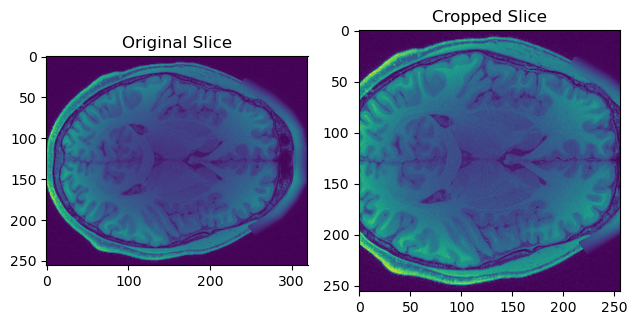

In [3]:
sliced = extract_MRI_slice('test_data/100206_MPR1.nii.gz')
print("Size of the original image: ", sliced.shape)

# Create a figure with a specific size
fig = plt.figure()

# Plotting the first image
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(sliced)
ax1.set_title("Original Slice")


sliced_crop = crop_center(sliced, 256)

print("Size of the cropped image: ", sliced_crop.shape)


# Plotting the cropped image
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(sliced_crop)
ax2.set_title("Cropped Slice")

# Adjust spacing and align the subplots
fig.tight_layout()

plt.show()

Target tensor shape:  torch.Size([4, 1, 128, 160])



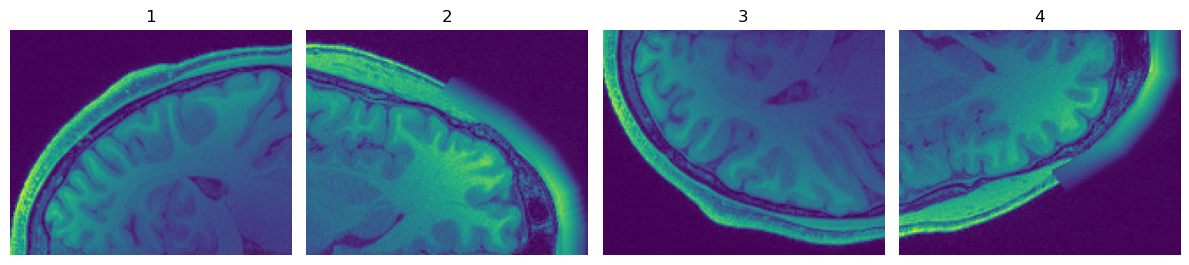

Target image shape:  (4, 1, 128, 160)
Number of patches:  4
Image ids:  [0, 1, 2, 3]


In [4]:
# In this Notebook this is only for the sake of initializing the fitting configuration
sliced_patches = divide_into_patches(sliced, (sliced.shape[0]//2, sliced.shape[1]//2))

batch_np = np.array(list(sliced_patches.values())).squeeze()[:,None,:,:]
target_tensor = torch.from_numpy(batch_np).type(dtype)
print('Target tensor shape: ', target_tensor.shape)
print()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(batch_np), figsize=(12, 4))  # Create a single row of subplots

for i, image in enumerate(batch_np):
    axes[i].imshow(image.squeeze())  # Assign each image to a subplot
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f'{i+1}')  # Set subplot title if desired

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the plot

original_image = sliced_patches[0,0] 
# Just to define a variable to extract the size in the 'fit_model_configuration.input_shape'
# Should be changed to make it automatic?
target_image=np.array(batch_np.tolist())

print('Target image shape: ',target_image.shape)

num_patches = len(sliced_patches)
image_ids = list(range(num_patches))
number_of_images_fitted = len(image_ids)


print('Number of patches: ', num_patches)
print('Image ids: ', image_ids)

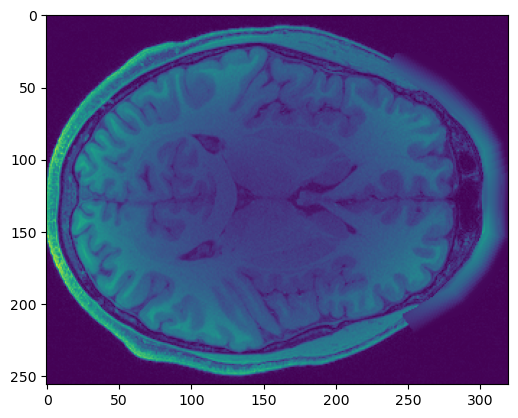

In [5]:
plt.imshow(merge_patches(sliced_patches))

In [6]:
sliced_patches = divide_into_patches(sliced, (sliced.shape[0]//2, sliced.shape[1]//2))


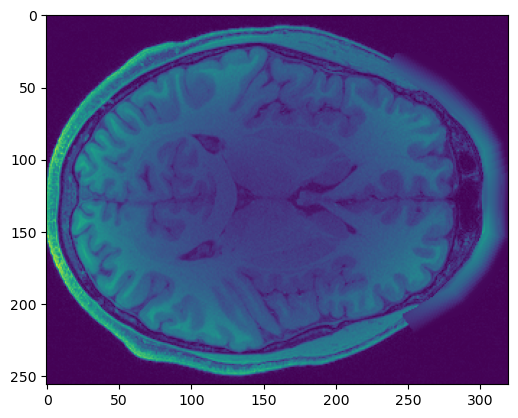

In [7]:
plt.imshow(merge_patches(sliced_patches))

In [8]:
sliced_patches[0,0].shape

(128, 160, 1)

# Fitting Configuration Class

In [9]:
"""
Define fitting configuration object controlling all relevant parameters
"""

import torch
import os


class FittingConfiguration:
    def __init__(self):
        self.image_dimensions = None
        self.result_path = None

        # Architecture Parameters
        self.model_type = 'deep'
        self.input_shape = None
        self.number_of_layers = 5
        self.number_of_hidden_channels = 32

        # Fitting Parameters
        self.number_of_iterations = 1500
        self.number_of_runs = 3
        self.learning_rate = 0.1
        self.convergence_check_length = None
        self.log_frequency = 100
        self.find_best = True
        self.save_losses = False
        self.constant_input = True
        self.compactness_parameter = 0.9
        blur_factor = 0.0001
        self.input_blur = 0
        self.lr_schedule_factor = 0.8

        if torch.cuda.is_available():
            self.data_type = torch.cuda.FloatTensor
        else:
            self.data_type = torch.FloatTensor

    def __str__(self):
        dictionary = self.__dict__
        result = ""
        for key in dictionary:
            result += key + ": " + str(dictionary[key]) + "  " + os.linesep
        return result

# 3D Fitter

In [10]:
import torch
import copy
import numpy as np

#from fitting.helpers import generate_random_variants
from utils.image_helpers import image_to_tensor, tensor_to_image

# The dropout reduction can be commented out in the Fitter.fit() function
DROPOUT_REDUCTION = {1: 0.8, 350: 0.4, 700: 0.2, 1050: 0.1, 1400: 0.05, 1750: 0.025, 2100: 0.0125, 2500: 0.0}


def create_fitter_from_configuration(configuration):
    fitter = Fitter(number_of_iterations=configuration.number_of_iterations,
                    learning_rate=configuration.learning_rate,
                    convergence_check_length=configuration.convergence_check_length,
                    log_frequency=configuration.log_frequency,
                    find_best=configuration.find_best,
                    data_type=configuration.data_type,
                    save_losses=configuration.save_losses,
                    constant_fixed_input=configuration.constant_input,
                    loss_weight=configuration.loss_weight,
                    input_blur=configuration.input_blur,
                    lr_schedule_factor=configuration.lr_schedule_factor)
    return fitter


class Fitter:
    def __init__(self, number_of_iterations, learning_rate=0.01, convergence_check_length=None, log_frequency=10,
                 find_best=False, data_type=torch.FloatTensor, save_losses=False, constant_fixed_input=False,
                 loss_weight=0.95, input_blur=0, lr_schedule_factor=0.5):
        self.loss_function = torch.nn.MSELoss().type(data_type)
        self.number_of_iterations = number_of_iterations
        self.learning_rate = learning_rate
        self.convergence_check_length = convergence_check_length
        self.log_frequency = log_frequency
        self.find_best = find_best
        self.data_type = data_type
        self.save_losses = save_losses
        self.constant_fixed_input = constant_fixed_input
        self.fixed_net_input = None
        self.model = None
        self.save_steps = False
        self.loss_weight = loss_weight
        self.input_blur = input_blur
        self.lr_schedule_factor = lr_schedule_factor

    def __call__(self, model, original_image, fixed_net_input, log_prefix=None, loss_mask=None):
        if self.model is None:
            self.model = model.type(self.data_type)
            self.optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 400, self.lr_schedule_factor)
            self.best_model = copy.deepcopy(self.model)
            self.best_model_step = 0
            self.best_model_loss = 1000
            self.step_images = []
            self.step_counter = 0

        self.fixed_net_input = fixed_net_input
        self.noisy_image = original_image
        
        self.optimizer = torch.optim.Adam(list(model.parameters()), lr=self.learning_rate) #+list(self.fixed_net_input)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 400, self.lr_schedule_factor)

        self.target_image = None

        if loss_mask is None:
            self.loss_mask = torch.ones(self.noisy_image.shape).type(self.data_type)
        else:
            self.loss_mask = torch.from_numpy(loss_mask).squeeze().type(self.data_type)[None, :, :].type(self.data_type)

        if self.save_losses:
            self.losses_wrt_noisy = []
            self.losses_wrt_target = []
        self.current_loss_wrt_noisy = 1000
        self.current_loss_wrt_target = 1000
        if log_prefix is None:
            self.log_prefix = ''
        else:
            self.log_prefix = log_prefix
        

        self.fit()

    def fit(self):
        while self.has_not_converged() and self.step_counter < self.number_of_iterations:
            def closure():
                self.optimizer.zero_grad()
                output = self.model(self.fixed_net_input)
                loss = self.loss_function(self.noisy_image, output)
                loss.backward()
                self.update_loss_metrics_and_best_model(loss, output)
                self.scheduler.step()
            self.optimizer.step(closure)
            self.step_counter += 1

            if self.should_log():
                self.log()

            if self.step_counter in DROPOUT_REDUCTION.keys():
                #print(f'Reduced to {DROPOUT_REDUCTION[self.step_counter]}.')
                for module in self.model.module_list[2:]:
                    if type(module) == torch.nn.modules.dropout.Dropout:
                        module.p = 0#DROPOUT_REDUCTION[self.step_counter]

    def has_not_converged(self):
        if self.convergence_check_length is None:
            return True
        elif self.step_counter < self.convergence_check_length:
            return True
        else:
            if self.best_model_step < self.step_counter - self.convergence_check_length:
                print(self.log_prefix + f'Converged at step {self.step_counter}.' + ' ' * 50, end='\r')
                return False
        return True

    def update_loss_metrics_and_best_model(self, current_loss_wrt_noisy, current_output):
        self.model.eval()
        self.current_loss_wrt_noisy = current_loss_wrt_noisy.data

        if self.save_losses:
            self.losses_wrt_noisy.append(self.current_loss_wrt_noisy)

        if self.target_image is not None:
            current_loss_wrt_target = self.loss_function(current_output, self.target_image)
            self.current_loss_wrt_target = current_loss_wrt_target.data
            if self.save_losses:
                self.losses_wrt_target.append(self.current_loss_wrt_target.data)

        if self.find_best:
            if self.step_counter > 0:
                if self.best_model_loss > 1.005 * current_loss_wrt_noisy.data:
                    self.best_model = copy.deepcopy(self.model)
                    self.best_model_step = self.step_counter
                    self.best_model_loss = current_loss_wrt_noisy.data
        elif self.step_counter == self.number_of_iterations - 1:
            self.best_model = copy.deepcopy(self.model)
            for params, best_params in zip(self.model.named_parameters(), self.best_model.named_parameters()):
                best_params[1].grad = params[1].grad
            self.best_model_step = self.step_counter
            self.best_model_loss = current_loss_wrt_noisy.data

        self.model.train()

    def should_log(self):
        if self.step_counter % self.log_frequency == 0:
            return True
        elif self.step_counter == self.number_of_iterations:
            return True
        else:
            return False

    def log(self):
        log_string = self.log_prefix
        log_string += f"Step: {self.step_counter:05d}"
        log_string += ", "
        log_string += f"Loss: {self.current_loss_wrt_noisy:.6f}"
        if self.target_image is not None:
            log_string += ", "
            log_string += f"Target Loss: {self.current_loss_wrt_target:.6f}"
        if self.find_best:
            log_string += ', '
            log_string += f'Minimum Loss at: {self.best_model_step} with {self.best_model_loss:.6f}'
        print(log_string, end='\r')

    def get_best_image(self):
        return self.best_model(self.fixed_net_input).detach().cpu()

# Deep Module

In [11]:
class DeepModule(nn.Module):
    def __init__(self, number_of_input_channels, number_of_output_channels, upsample_size,
                 upsample_mode='bilinear', bn=True):
        self.bn = bn
        if number_of_input_channels is None:
            number_of_input_channels = number_of_output_channels
        super(DeepModule, self).__init__()
        self.convolution_layer = nn.Conv2d(in_channels=number_of_input_channels, out_channels=number_of_output_channels,
                                           kernel_size=1, stride=1, bias=False)
        self.upsample_layer = nn.Upsample(size=upsample_size, mode=upsample_mode, align_corners=True)
        self.activation_layer = nn.ReLU()
        if self.bn:
            # In the original paper they used batch norm. They only used batches of size one. 
            # Hence, in this setup we had to change it to InstanceNorm s.t. the normalization happens channelwise.
            self.batch_normalization = nn.InstanceNorm2d(num_features=number_of_output_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    def forward(self, module_input):
        x = self.convolution_layer(module_input)
        x = self.upsample_layer(x)
        x = self.activation_layer(x)
        if self.bn:
            x = self.batch_normalization(x)
        return x


class DeepDecoder(nn.Module):
    def __init__(self, input_shape, image_dimensions, number_of_layers, number_of_hidden_channels, upsample_sizes=None):
        super(DeepDecoder, self).__init__()
        self.input_shape = [1, number_of_hidden_channels] + input_shape
        self.image_dimensions = image_dimensions[:2]
        self.number_of_layers = number_of_layers
        self.number_of_hidden_channels = number_of_hidden_channels
        self.number_of_output_channels = image_dimensions[2]

        # Initialize Module List to be filled with Module consisting of layers
        self.module_list = nn.ModuleList()

        # Fill Module List with Modules consisting of Reflection, Convolution, Upsampling, ReLU and Batch Normalization
        if number_of_layers > 0:
            if upsample_sizes is None:
                upsample_sizes = calculate_upsample_sizes(input_shape, self.image_dimensions, number_of_layers)
            for layer_index, upsample_size in enumerate(upsample_sizes):
                self.module_list.append(DeepModule(number_of_hidden_channels, number_of_hidden_channels, upsample_size, bn=True))

        # Add final module
        self.module_list.append(nn.Conv2d(in_channels=number_of_hidden_channels,
                                          out_channels=self.number_of_output_channels,
                                          kernel_size=1,
                                          stride=1,
                                          bias=False))
        self.module_list.append(nn.Sigmoid())


    def forward(self, x):
        for module in self.module_list:
            x = module(x)
        return x

    def get_input_shape(self):
        return self.input_shape

    def __str__(self):
        output_string = "Deep Decoder "
        output_string += str(self.input_shape[-2:])
        output_string += ", "
        output_string += str(self.number_of_layers)
        output_string += ", "
        output_string += str(self.number_of_hidden_channels)
        return output_string

    def get_model_parameters(self):
        return ['deep', self.input_shape[-2:], self.number_of_layers, self.number_of_hidden_channels]


def calculate_upsample_sizes(input_shape, output_shape, number_of_layers):
    scale = (np.array(output_shape) / np.array(input_shape)) ** (1 / number_of_layers)
    upsample_sizes = [np.ceil(np.array(input_shape) * (scale ** n)).astype(int).tolist() for n in
                      range(1, number_of_layers)] + [output_shape]
    return upsample_sizes

def create_model_from_configuration(fit_model_configuration):
    model = DeepDecoder(input_shape=fit_model_configuration.input_shape,
                        image_dimensions=fit_model_configuration.image_dimensions,
                        number_of_layers=fit_model_configuration.number_of_layers,
                        number_of_hidden_channels=fit_model_configuration.number_of_hidden_channels)
    return model


class DecoderEnsemble:
    def __init__(self):
        self.decoders = []
        self.start_inputs = []
        self.input_deltas = []
    
    def add_decoder(self, decoder, start_input, input_delta):
        self.decoders.append(decoder)
        self.start_inputs.append(start_input)
        self.input_deltas.append(input_delta)
        
    def evaluate(self, z, num_dds=None):
        preds = []
        for decoder, start_input, input_delta in zip(self.decoders, self.start_inputs, self.input_deltas):
            input_tensor = start_input + z*input_delta*STEP_SIZE
            pred = decoder(input_tensor.type(dtype)).cpu().detach().numpy()
            preds.append(pred.squeeze())
        return np.mean(preds[:num_dds], axis=0)
    
    def predict_volume(self, z_1, z_2, num_frames=None, num_dds=None):
        assert isinstance(z_1, int) and isinstance(z_2, int)
        assert z_2 > z_1
        if num_dds is None:
            num_dds = len(self.decoders)
        if num_frames is None:
            num_frames = z_2 - z_1
        frames = []
        for z in np.linspace(z_1, z_2, num_frames):
            frames.append(self.evaluate(z, num_dds))
        return np.transpose(np.array(frames), [1,2,0])
    
    def get_features(self, z):
        feature_maps = []
        for decoder, start_input, input_delta in zip(self.decoders, self.start_inputs, self.input_deltas):
            input_tensor = start_input + z*input_delta*STEP_SIZE
            
            activation = {}
            def get_activation(name):
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook

            hook = decoder.module_list[-3].register_forward_hook(get_activation(f'act'))
            _ = decoder(input_tensor.type(dtype))

            act_maps = list(activation['act'].squeeze().cpu().numpy())
            weights = list(decoder.module_list[-2].weight.detach().squeeze().cpu().numpy())
            feature_maps.extend([a*w for a,w in zip(act_maps, weights)])
            hook.remove()
        return feature_maps

# Fitting Setup

In [12]:

fit_model_configuration = FittingConfiguration()

fit_model_configuration.model_type = 'deep'

fit_model_configuration.number_of_hidden_channels = int(64)
fit_model_configuration.number_of_layers = 5
fit_model_configuration.number_of_iterations = 2000

fit_model_configuration.log_frequency = 50
fit_model_configuration.convergence_check_length = None
fit_model_configuration.result_path = None
fit_model_configuration.save_losses = True
fit_model_configuration.find_best = True
fit_model_configuration.constant_input = True
fit_model_configuration.input_shape = [original_image.shape[0]//5, original_image.shape[1]//5]
fit_model_configuration.image_dimensions =  [target_tensor.shape[2], target_tensor.shape[3], target_tensor.shape[1]]
fit_model_configuration.number_of_runs = 5


fit_model_configuration.lr_schedule_factor = 0.6
fit_model_configuration.loss_weight = 1.0#0.95

print(fit_model_configuration)

conv_maps = []#np.zeros((0, original_image.shape[0], original_image.shape[0]))
preds = []
weights = np.zeros((target_image.shape[2], 0))

decoder = create_model_from_configuration(fit_model_configuration)
param_num = np.sum([weight.numel() for weight in decoder.parameters()])
print(f'Number of Parameters: {param_num}')
#print(f'Compression per Decoder: {param_num*32/volume.size*100:0.2f}%') # param_num * 32 because float32
#print(f'Compression Ensemble: {param_num*32/volume.size*100*fit_model_configuration.number_of_runs:0.2f}%')
#print('Compression rates given in: Weights [bits] / Volume')

image_dimensions: [128, 160, 1]  
result_path: None  
model_type: deep  
input_shape: [25, 32]  
number_of_layers: 5  
number_of_hidden_channels: 64  
number_of_iterations: 2000  
number_of_runs: 5  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 50  
find_best: True  
save_losses: True  
constant_input: True  
compactness_parameter: 0.9  
input_blur: 0  
lr_schedule_factor: 0.6  
data_type: <class 'torch.cuda.FloatTensor'>  
loss_weight: 1.0  

Number of Parameters: 21184


# Input Generation

In [13]:
def generate_random_variants(number_of_hidden_channels, input_size, blur=0):
    input_images = []
    gen_counter = 0

    while len(input_images) < number_of_hidden_channels and gen_counter < number_of_hidden_channels * 5:
        noise = np.random.uniform(low=0, high=1, size=[*input_size])
        if blur == 0:
            convolution = noise
        else:
            convolution = cv2.GaussianBlur(noise, (blur, blur), 0)
            convolution = convolution - np.min(convolution)
            convolution = convolution / np.max(convolution)
            convolution = 2 * convolution - 1

        input_images.append(convolution)

        gen_counter += 1
    for _ in range(number_of_hidden_channels - len(input_images)):
        input_images.append(np.zeros([input_size] * 2))
    return input_images

STEP_SIZE = 0.08
def generate_inputs(num, step_size=STEP_SIZE, blur=3):
    """
    Generate two random noise fields with the function generate_random_variants and linearly interpolate between them to generate "3D" input such that each
    input slice maps to one slice of the target volume.
    """
    
    inputs = []
    fixed_net_input = torch.zeros(size=[number_of_images_fitted,fit_model_configuration.number_of_hidden_channels]+fit_model_configuration.input_shape)
    start_input = torch.from_numpy(np.array(generate_random_variants(fit_model_configuration.number_of_hidden_channels, fit_model_configuration.input_shape, blur))).unsqueeze(0)
    end_input = torch.from_numpy(np.array(generate_random_variants(fit_model_configuration.number_of_hidden_channels, fit_model_configuration.input_shape, blur))).unsqueeze(0) + 0.1
    delta = (end_input-start_input)

    for z in range(num):
        fixed_net_input[z] = start_input + z*delta*step_size
    fixed_net_input = fixed_net_input.type(dtype)
    
    return fixed_net_input, start_input, delta



fixed_net_input, start_input, delta = generate_inputs(len(image_ids))
print(fixed_net_input.shape)

def divide_samples_into_patches(samples, patch_size):
    num_samples = samples.shape[0]
    patch_height, patch_width = patch_size
    num_rows = samples.shape[1] // patch_height
    num_cols = samples.shape[2] // patch_width
    patches = np.empty((num_rows * num_cols, num_samples, patch_height, patch_width))

    for s in range(num_samples):
        image = samples[s]
        patch_index = 0
        for r in range(num_rows):
            for c in range(num_cols):
                patch = image[r*patch_height:(r+1)*patch_height, c*patch_width:(c+1)*patch_width]
                patches[patch_index, s] = patch
                patch_index += 1

    return patches



torch.Size([4, 64, 25, 32])


In [14]:
fit_model_configuration.image_dimensions 

[128, 160, 1]

In [15]:
number_of_hidden_channels = fit_model_configuration.number_of_hidden_channels
input_size = fit_model_configuration.input_shape
blur = 0

random_variants = np.array(generate_random_variants(number_of_hidden_channels, 
                                            input_size= (2*input_size[0],2*input_size[1]), # Check this out!
                                            blur = blur))

noise_batch = divide_samples_into_patches(random_variants, (input_size[0],input_size[1]))
test_gauss_input = torch.from_numpy(noise_batch).type(dtype)
        

In [16]:
random_variants.shape

(64, 50, 64)

In [17]:
input_size

[25, 32]

# Grid Search with a Single Decoder Fitting Patches (No Blur)

In [ ]:
'''
# Define target image
if 'original_image' in locals():
    del original_image

if 'target_tensor' in locals():
    del target_tensor
# Original image must be (H,W,C)
# Target tensor must be (Batch_size, C, H, W)
sliced =  extract_MRI_slice('test_data/100206_MPR1.nii.gz')
sliced_patches = divide_into_patches(sliced, (sliced.shape[0]//2, sliced.shape[1]//2))
original_image = sliced_patches[0,0]
batch_np = np.array(list(sliced_patches.values())).squeeze()[:,None,:,:]
target_tensor = torch.from_numpy(batch_np).type(dtype)

print('Original image shape: ', original_image.shape)
print('Target tensor shape: ', target_tensor.shape)
print()

# Define candidate values for each parameter
fit_model_configuration.image_dimensions = [target_tensor.shape[2], target_tensor.shape[3], target_tensor.shape[1]]

number_of_hidden_channels_values = [8, 16, 32, 64, int(64*1.5), 64*2, 64*3]
input_shape_values = [[original_image.shape[0] // 2**5, original_image.shape[1] // 2**5],
                      [original_image.shape[0] // 2**4, original_image.shape[1] // 2**4],
                      [original_image.shape[0] // 2**3, original_image.shape[1] // 2**3]]
                        

# [original_image.shape[0] // 5, original_image.shape[1] // 5]]

number_of_layers_values = [4, 5, 6]
number_of_iterations_values = [2000, 5000, 7000]

# Initialize variables
best_psnr = 0
best_ssim = 0
best_mssim = 0
best_vif = 0

best_psnr_configuration = None
best_ssim_configuration = None
best_mssim_configuration = None
best_vif_configuration = None

with open('grid_search_results_patches_4_1DD_blur_0.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Run', 'Number_of_hidden_channels', 'Input_shape', 'Number_of_layers', 'Number_of_iterations',
                     'PSNR', 'SSIM', 'VIF', 'Number_of_parameters', 'Execution_time'])

    for count, config in enumerate(itertools.product(number_of_hidden_channels_values, input_shape_values,
                                                     number_of_layers_values, number_of_iterations_values)):
        
                
        decoder = None
        fitter = None
        output = None

        fit_model_configuration.number_of_hidden_channels = config[0]
        fit_model_configuration.input_shape = config[1]
        fit_model_configuration.number_of_layers = config[2]
        fit_model_configuration.number_of_iterations = config[3]

        print(f'Run {count}:')
        print('number_of_hidden_channels:', fit_model_configuration.number_of_hidden_channels)
        print('input_shape:', fit_model_configuration.input_shape)
        print('number_of_layers:', fit_model_configuration.number_of_layers)
        print('number_of_iterations:', fit_model_configuration.number_of_iterations)
        print()

        # Define noise input (THIS IS DIFFERENT IN BY BATCH PROCESSING)

        number_of_hidden_channels = fit_model_configuration.number_of_hidden_channels
        input_size = fit_model_configuration.input_shape
        blur = 0
        
        random_variants = np.array(generate_random_variants(number_of_hidden_channels, 
                                                    input_size= (2*input_size[0],2*input_size[1]), # Check this out!
                                                    blur = blur))
        
        noise_batch = divide_samples_into_patches(random_variants, (input_size[0],input_size[1]))
        test_gauss_input = torch.from_numpy(noise_batch).type(dtype)
        
        
        
        #input_noise_whole = generate_random_variants(number_of_hidden_channels, input_size, blur)
        #input_noise_whole_tensor = torch.from_numpy(np.array(input_noise_whole)[None, :, :, :]).type(dtype)

        # Fit decoder
        start_time = time.time()

        for run_index in range(1):
            decoder = create_model_from_configuration(fit_model_configuration)
            fitter = create_fitter_from_configuration(fit_model_configuration)
            fitter(decoder, target_tensor, test_gauss_input)
            print('Fitting done.')
            
            
        param_num = np.sum([weight.numel() for weight in decoder.parameters()])
        print(f'Number of Parameters: {param_num}')
        print()

        output = decoder(test_gauss_input).detach().type(dtype)

        current_psnr = psnr(target_tensor, output).item()
        current_ssim = ssim(target_tensor, output).item()
        #current_mssim = multi_scale_ssim(target_tensor, output).item()
        current_vif = vif_p(target_tensor, output, sigma_n_sq=np.mean(original_image)).item()

        print('PSNR: ', current_psnr)
        print('SSIM: ', current_ssim)
        #print('MS-SSIM: ', current_mssim)
        print('VIF: ', current_vif)

        print()

        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Processing time: {execution_time} seconds")
        print()
        print('-------------------------------------------------------------------------------------')

        # Write the data to the CSV file (I HAVE ELIMINATED MSSIM BECAUSE IT GIVES PROBLEMS WITH SMALLER SIZES)
        writer.writerow([count, fit_model_configuration.number_of_hidden_channels, fit_model_configuration.input_shape,
                         fit_model_configuration.number_of_layers, fit_model_configuration.number_of_iterations,
                         current_psnr, current_ssim, current_vif, param_num, execution_time])

        # Check if current configuration has the best metric and update the corresponding best value
        if current_psnr > best_psnr:
            best_psnr = current_psnr
            best_psnr_configuration = config

        if current_ssim > best_ssim:
            best_ssim = current_ssim
            best_ssim_configuration = config

        #if current_mssim > best_mssim:
        #    best_mssim = current_mssim
        #    best_mssim_configuration = config

        if current_vif > best_vif:
            best_vif = current_vif
            best_vif_configuration = config

# Print best configuration and metrics

print('Best PSNR:', best_psnr)
print('Best PSNR Configuration:', best_psnr_configuration)
print('Best SSIM:', best_ssim)
print('Best SSIM Configuration:', best_ssim_configuration)
#print('Best MS-SSIM:', best_mssim)
#print('Best MS-SIM Configuration:', best_mssim_configuration)
print('Best VIF:', best_vif)
print('Best VIF Configuration:', best_vif_configuration)
'''


# Figure

In [20]:
# Define target image
if 'original_image' in locals():
    del original_image

if 'target_tensor' in locals():
    del target_tensor
# Original image must be (H,W,C)
# Target tensor must be (Batch_size, C, H, W)
sliced =  extract_MRI_slice('test_data/100206_MPR1.nii.gz')
sliced_patches = divide_into_patches(sliced, (sliced.shape[0]//2, sliced.shape[1]//2))
original_image = sliced_patches[0,0]
batch_np = np.array(list(sliced_patches.values())).squeeze()[:,None,:,:]
target_tensor = torch.from_numpy(batch_np).type(dtype)

print('Original image shape: ', original_image.shape)
print('Target tensor shape: ', target_tensor.shape)
print()

# Define candidate values for each parameter
fit_model_configuration.image_dimensions = [target_tensor.shape[2], target_tensor.shape[3], target_tensor.shape[1]]

number_of_hidden_channels_values = [64]
input_shape_values = [[original_image.shape[0] // 2**4, original_image.shape[1] // 2**4]]
                        

# [original_image.shape[0] // 5, original_image.shape[1] // 5]]

number_of_layers_values = [4]
number_of_iterations_values = [2000]

# Initialize variables
best_psnr = 0
best_ssim = 0
best_mssim = 0
best_vif = 0

best_psnr_configuration = None
best_ssim_configuration = None
best_mssim_configuration = None
best_vif_configuration = None

with open('agrid_search_results_patches_4_1DD_blur_0.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Run', 'Number_of_hidden_channels', 'Input_shape', 'Number_of_layers', 'Number_of_iterations',
                     'PSNR', 'SSIM', 'VIF', 'Number_of_parameters', 'Execution_time'])

    for count, config in enumerate(itertools.product(number_of_hidden_channels_values, input_shape_values,
                                                     number_of_layers_values, number_of_iterations_values)):
        
                
        decoder = None
        fitter = None
        output = None

        fit_model_configuration.number_of_hidden_channels = config[0]
        fit_model_configuration.input_shape = config[1]
        fit_model_configuration.number_of_layers = config[2]
        fit_model_configuration.number_of_iterations = config[3]

        print(f'Run {count}:')
        print('number_of_hidden_channels:', fit_model_configuration.number_of_hidden_channels)
        print('input_shape:', fit_model_configuration.input_shape)
        print('number_of_layers:', fit_model_configuration.number_of_layers)
        print('number_of_iterations:', fit_model_configuration.number_of_iterations)
        print()

        # Define noise input (THIS IS DIFFERENT IN BY BATCH PROCESSING)

        number_of_hidden_channels = fit_model_configuration.number_of_hidden_channels
        input_size = fit_model_configuration.input_shape
        blur = 3
        
        random_variants = np.array(generate_random_variants(number_of_hidden_channels, 
                                                    input_size= (2*input_size[0],2*input_size[1]), # Check this out!
                                                    blur = blur))
        
        noise_batch = divide_samples_into_patches(random_variants, (input_size[0],input_size[1]))
        test_gauss_input = torch.from_numpy(noise_batch).type(dtype)
        
        
        
        #input_noise_whole = generate_random_variants(number_of_hidden_channels, input_size, blur)
        #input_noise_whole_tensor = torch.from_numpy(np.array(input_noise_whole)[None, :, :, :]).type(dtype)

        # Fit decoder
        start_time = time.time()

        for run_index in range(1):
            decoder = create_model_from_configuration(fit_model_configuration)
            fitter = create_fitter_from_configuration(fit_model_configuration)
            fitter(decoder, target_tensor, test_gauss_input)
            print('Fitting done.')
            
            
        param_num = np.sum([weight.numel() for weight in decoder.parameters()])
        print(f'Number of Parameters: {param_num}')
        print()

        output = decoder(test_gauss_input).detach().type(dtype)

        current_psnr = psnr(target_tensor, output).item()
        current_ssim = ssim(target_tensor, output).item()
        #current_mssim = multi_scale_ssim(target_tensor, output).item()
        current_vif = vif_p(target_tensor, output, sigma_n_sq=np.mean(original_image)).item()

        print('PSNR: ', current_psnr)
        print('SSIM: ', current_ssim)
        #print('MS-SSIM: ', current_mssim)
        print('VIF: ', current_vif)

        print()

        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Processing time: {execution_time} seconds")
        print()
        print('-------------------------------------------------------------------------------------')

        # Write the data to the CSV file (I HAVE ELIMINATED MSSIM BECAUSE IT GIVES PROBLEMS WITH SMALLER SIZES)
        writer.writerow([count, fit_model_configuration.number_of_hidden_channels, fit_model_configuration.input_shape,
                         fit_model_configuration.number_of_layers, fit_model_configuration.number_of_iterations,
                         current_psnr, current_ssim, current_vif, param_num, execution_time])

        # Check if current configuration has the best metric and update the corresponding best value
        if current_psnr > best_psnr:
            best_psnr = current_psnr
            best_psnr_configuration = config

        if current_ssim > best_ssim:
            best_ssim = current_ssim
            best_ssim_configuration = config

        #if current_mssim > best_mssim:
        #    best_mssim = current_mssim
        #    best_mssim_configuration = config

        if current_vif > best_vif:
            best_vif = current_vif
            best_vif_configuration = config

# Print best configuration and metrics

print('Best PSNR:', best_psnr)
print('Best PSNR Configuration:', best_psnr_configuration)
print('Best SSIM:', best_ssim)
print('Best SSIM Configuration:', best_ssim_configuration)
#print('Best MS-SSIM:', best_mssim)
#print('Best MS-SIM Configuration:', best_mssim_configuration)
print('Best VIF:', best_vif)
print('Best VIF Configuration:', best_vif_configuration)



Original image shape:  (128, 160, 1)
Target tensor shape:  torch.Size([4, 1, 128, 160])

Run 0:
number_of_hidden_channels: 64
input_shape: [8, 10]
number_of_layers: 4
number_of_iterations: 2000

Fitting done.Loss: 0.000855, Minimum Loss at: 1999 with 0.000855
Number of Parameters: 16960

PSNR:  30.787567138671875
SSIM:  0.7910602688789368
VIF:  0.33516648411750793

Processing time: 21.35241937637329 seconds

-------------------------------------------------------------------------------------
Best PSNR: 30.787567138671875
Best PSNR Configuration: (64, [8, 10], 4, 2000)
Best SSIM: 0.7910602688789368
Best SSIM Configuration: (64, [8, 10], 4, 2000)
Best VIF: 0.33516648411750793
Best VIF Configuration: (64, [8, 10], 4, 2000)


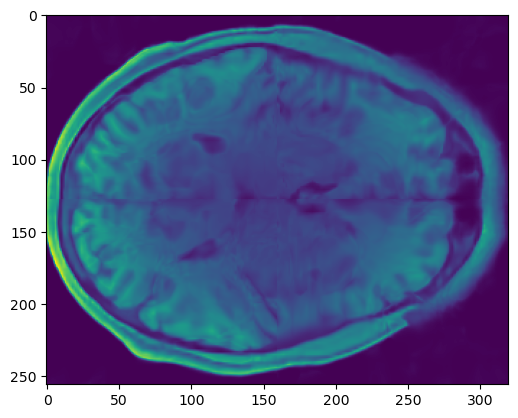

In [21]:
a = output.detach().cpu().numpy().squeeze()
a = a.reshape(2, 2, 128, 160).transpose(0, 2, 1, 3).reshape(2*128, 2*160)
plt.imshow(a)
              

In [ ]:
#output = decoder(test_gauss_input).detach().cpu().numpy().squeeze()

In [ ]:
#plt.imshow(output[0][0])

In [ ]:
'''
output = decoder(test_gauss_input).detach().cpu().numpy().squeeze()

# Assuming you have the patches stored in a variable called "patches" with shape (20, 64, 64)
num_rows = 2
num_cols = 2

# Reshape the patches to form a grid
patches_reshaped = output.reshape(num_rows, num_cols, 128, 160)

# Transpose the axes to rearrange the grid
patches_transposed = patches_reshaped.transpose(0, 2, 1, 3)

# Reshape and combine the patches to form the original image
image_out_n = patches_transposed.reshape(num_rows * 128, num_cols * 160)

# Verify the shape of the resulting image
plt.imshow(image_out_n)
plt.show()
'''

In [ ]:
'''
output = decoder(test_gauss_input).detach().type(dtype)
current_psnr = psnr(target_tensor, output).item()
print(current_psnr)
'''

# Grid Search with a Single Decoder Fitting Patches (Blur = 3)

In [ ]:
# Define target image
if 'original_image' in locals():
    del original_image

if 'target_tensor' in locals():
    del target_tensor
# Original image must be (H,W,C)
# Target tensor must be (Batch_size, C, H, W)
sliced =  extract_MRI_slice('test_data/100206_MPR1.nii.gz')
sliced_patches = divide_into_patches(sliced, (sliced.shape[0]//2, sliced.shape[1]//2))
original_image = sliced_patches[0,0]
batch_np = np.array(list(sliced_patches.values())).squeeze()[:,None,:,:]
target_tensor = torch.from_numpy(batch_np).type(dtype)

print('Original image shape: ', original_image.shape)
print('Target tensor shape: ', target_tensor.shape)
print()

# Define candidate values for each parameter
fit_model_configuration.image_dimensions = [target_tensor.shape[2], target_tensor.shape[3], target_tensor.shape[1]]

number_of_hidden_channels_values = [8, 16, 32, 64, int(64*1.5), 64*2, 64*3]
input_shape_values = [[original_image.shape[0] // 2**5, original_image.shape[1] // 2**5],
                      [original_image.shape[0] // 2**4, original_image.shape[1] // 2**4],
                      [original_image.shape[0] // 2**3, original_image.shape[1] // 2**3]]
                        

# [original_image.shape[0] // 5, original_image.shape[1] // 5]]

number_of_layers_values = [4, 5, 6]
number_of_iterations_values = [2000, 5000, 7000]

# Initialize variables
best_psnr = 0
best_ssim = 0
best_mssim = 0
best_vif = 0

best_psnr_configuration = None
best_ssim_configuration = None
best_mssim_configuration = None
best_vif_configuration = None

with open('grid_search_results_patches_4_1DD_blur_3.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Run', 'Number_of_hidden_channels', 'Input_shape', 'Number_of_layers', 'Number_of_iterations',
                     'PSNR', 'SSIM', 'VIF', 'Number_of_parameters', 'Execution_time'])

    for count, config in enumerate(itertools.product(number_of_hidden_channels_values, input_shape_values,
                                                     number_of_layers_values, number_of_iterations_values)):
        
                
        decoder = None
        fitter = None
        output = None

        fit_model_configuration.number_of_hidden_channels = config[0]
        fit_model_configuration.input_shape = config[1]
        fit_model_configuration.number_of_layers = config[2]
        fit_model_configuration.number_of_iterations = config[3]

        print(f'Run {count}:')
        print('number_of_hidden_channels:', fit_model_configuration.number_of_hidden_channels)
        print('input_shape:', fit_model_configuration.input_shape)
        print('number_of_layers:', fit_model_configuration.number_of_layers)
        print('number_of_iterations:', fit_model_configuration.number_of_iterations)
        print()

        # Define noise input (THIS IS DIFFERENT IN BY BATCH PROCESSING)

        number_of_hidden_channels = fit_model_configuration.number_of_hidden_channels
        input_size = fit_model_configuration.input_shape
        blur = 3
        
        random_variants = np.array(generate_random_variants(number_of_hidden_channels, 
                                                    input_size= (2*input_size[0],2*input_size[1]), # Check this out!
                                                    blur = blur))
        
        noise_batch = divide_samples_into_patches(random_variants, (input_size[0],input_size[1]))
        test_gauss_input = torch.from_numpy(noise_batch).type(dtype)
        
        
        
        #input_noise_whole = generate_random_variants(number_of_hidden_channels, input_size, blur)
        #input_noise_whole_tensor = torch.from_numpy(np.array(input_noise_whole)[None, :, :, :]).type(dtype)

        # Fit decoder
        start_time = time.time()

        for run_index in range(1):
            decoder = create_model_from_configuration(fit_model_configuration)
            fitter = create_fitter_from_configuration(fit_model_configuration)
            fitter(decoder, target_tensor, test_gauss_input)
            print('Fitting done.')
            
            
        param_num = np.sum([weight.numel() for weight in decoder.parameters()])
        print(f'Number of Parameters: {param_num}')
        print()

        output = decoder(test_gauss_input).detach().type(dtype)

        current_psnr = psnr(target_tensor, output).item()
        current_ssim = ssim(target_tensor, output).item()
        #current_mssim = multi_scale_ssim(target_tensor, output).item()
        current_vif = vif_p(target_tensor, output, sigma_n_sq=np.mean(original_image)).item()

        print('PSNR: ', current_psnr)
        print('SSIM: ', current_ssim)
        #print('MS-SSIM: ', current_mssim)
        print('VIF: ', current_vif)

        print()

        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Processing time: {execution_time} seconds")
        print()
        print('-------------------------------------------------------------------------------------')

        # Write the data to the CSV file (I HAVE ELIMINATED MSSIM BECAUSE IT GIVES PROBLEMS WITH SMALLER SIZES)
        writer.writerow([count, fit_model_configuration.number_of_hidden_channels, fit_model_configuration.input_shape,
                         fit_model_configuration.number_of_layers, fit_model_configuration.number_of_iterations,
                         current_psnr, current_ssim, current_vif, param_num, execution_time])

        # Check if current configuration has the best metric and update the corresponding best value
        if current_psnr > best_psnr:
            best_psnr = current_psnr
            best_psnr_configuration = config

        if current_ssim > best_ssim:
            best_ssim = current_ssim
            best_ssim_configuration = config

        #if current_mssim > best_mssim:
        #    best_mssim = current_mssim
        #    best_mssim_configuration = config

        if current_vif > best_vif:
            best_vif = current_vif
            best_vif_configuration = config

# Print best configuration and metrics

print('Best PSNR:', best_psnr)
print('Best PSNR Configuration:', best_psnr_configuration)
print('Best SSIM:', best_ssim)
print('Best SSIM Configuration:', best_ssim_configuration)
#print('Best MS-SSIM:', best_mssim)
#print('Best MS-SIM Configuration:', best_mssim_configuration)
print('Best VIF:', best_vif)
print('Best VIF Configuration:', best_vif_configuration)


# Grid Search Fitting a Single Slice with 5 Decoders (No Blur)

In [ ]:
# Define target image
if 'original_image' in locals():
    del original_image

if 'target_tensor' in locals():
    del target_tensor
# Original image must be (H,W,C)
# Target tensor must be (Batch_size, C, H, W)


sliced =  extract_MRI_slice('test_data/100206_MPR1.nii.gz')
sliced_patches = divide_into_patches(sliced, (sliced.shape[0]//2, sliced.shape[1]//2))
original_image = sliced_patches[0,0]
batch_np = np.array(list(sliced_patches.values())).squeeze()[:,None,:,:]
target_tensor = torch.from_numpy(batch_np).type(dtype)

print('Original image shape: ', original_image.shape)
print('Target tensor shape: ', target_tensor.shape)
print()

# Define candidate values for each parameter
fit_model_configuration.image_dimensions = [target_tensor.shape[2], target_tensor.shape[3], target_tensor.shape[1]]
number_of_hidden_channels_values = [8, 16, 32, 64, int(64*1.5), 64*2, 64*3]
input_shape_values = [[original_image.shape[0] // 2**5, original_image.shape[1] // 2**5],
                      [original_image.shape[0] // 2**4, original_image.shape[1] // 2**4],
                      [original_image.shape[0] // 2**3, original_image.shape[1] // 2**3]]
number_of_layers_values = [4, 5, 6]
number_of_iterations_values = [2000, 5000, 7000]

# Initialize variables
best_psnr = 0
best_ssim = 0
best_mssim = 0
best_vif = 0

best_psnr_configuration = None
best_ssim_configuration = None
best_mssim_configuration = None
best_vif_configuration = None

with open('grid_search_results_patches_4_5DD_blur_0.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Run', 'Number_of_hidden_channels', 'Input_shape', 'Number_of_layers', 'Number_of_iterations',
                     'PSNR','PSNR Variance', 'SSIM', 'VIF', 'Number_of_parameters', 'Execution_time'])

    for count, config in enumerate(itertools.product(number_of_hidden_channels_values, input_shape_values,
                                                     number_of_layers_values, number_of_iterations_values)):
        
                
        decoder = None
        fitter = None
        output = None

        fit_model_configuration.number_of_hidden_channels = config[0]
        fit_model_configuration.input_shape = config[1]
        fit_model_configuration.number_of_layers = config[2]
        fit_model_configuration.number_of_iterations = config[3]

        print(f'Run {count}:')
        print('number_of_hidden_channels:', fit_model_configuration.number_of_hidden_channels)
        print('input_shape:', fit_model_configuration.input_shape)
        print('number_of_layers:', fit_model_configuration.number_of_layers)
        print('number_of_iterations:', fit_model_configuration.number_of_iterations)
        print()

        number_of_hidden_channels = fit_model_configuration.number_of_hidden_channels
        input_size = fit_model_configuration.input_shape
        blur = 0

        # Fit decoder
        start_time = time.time()
        outputs = []
        psnr_run = []
        
        num = 5
        for run_index in range(num):
            if run_index > 0:
                del decoder,fitter,output #Just in case
            print('Decoder ',run_index)
            decoder = create_model_from_configuration(fit_model_configuration)
            fitter = create_fitter_from_configuration(fit_model_configuration)
                    
            random_variants = np.array(generate_random_variants(number_of_hidden_channels, 
                                                    input_size= (2*input_size[0],2*input_size[1]), # Check this out!
                                                    blur = blur))
        
            noise_batch = divide_samples_into_patches(random_variants, (input_size[0],input_size[1]))
            test_gauss_input = torch.from_numpy(noise_batch).type(dtype)

            fitter(decoder, target_tensor, test_gauss_input)

            output = decoder(test_gauss_input).detach().type(dtype)
            outputs.append(output)
            
            print()
                        
            param_num = np.sum([weight.numel() for weight in decoder.parameters()])
            print(f'Number of Parameters: {param_num}')
            print()
            
            psnr_run.append(psnr(target_tensor, output).item())
            
            print('PSNR: ', psnr(target_tensor, output).item())
            print()
        
        # Compute averaged output and PSNR variance to check for stability
        psnr_variance=0
        psnr_variance = np.var(psnr_run)
        print('PSNR Variance among decoders: ',psnr_variance)
        if run_index > 0:
            del psnr_run
        averaged_output = torch.mean(torch.stack(outputs), dim=0)

        current_psnr = psnr(target_tensor, averaged_output).item()
        current_ssim = ssim(target_tensor, averaged_output).item()
        #current_mssim = multi_scale_ssim(target_tensor, averaged_output).item()
        current_vif = vif_p(target_tensor, averaged_output, sigma_n_sq=np.mean(original_image)).item()
        
        print('Ensemble metrics:')
        print('PSNR: ', current_psnr)
        print('SSIM: ', current_ssim)
        #print('MS-SSIM: ', current_mssim)
        print('VIF: ', current_vif)

        print()

        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Processing time: {execution_time} seconds")
        print()
        print('-------------------------------------------------------------------------------------')

        # Write the data to the CSV file
        writer.writerow([count, fit_model_configuration.number_of_hidden_channels, fit_model_configuration.input_shape,
                         fit_model_configuration.number_of_layers, fit_model_configuration.number_of_iterations,
                         current_psnr,psnr_variance, current_ssim, current_vif, param_num, execution_time])

        # Check if current configuration has the best metric and update the corresponding best value
        if current_psnr > best_psnr:
            best_psnr = current_psnr
            best_psnr_configuration = config

        if current_ssim > best_ssim:
            best_ssim = current_ssim
            best_ssim_configuration = config

        #if current_mssim > best_mssim:
        #    best_mssim = current_mssim
        #    best_mssim_configuration = config

        if current_vif > best_vif:
            best_vif = current_vif
            best_vif_configuration = config

# Print best configuration and metrics

print('Best PSNR:', best_psnr)
print('Best PSNR Configuration:', best_psnr_configuration)
print('Best SSIM:', best_ssim)
print('Best SSIM Configuration:', best_ssim_configuration)
#print('Best MS-SSIM:', best_mssim)
#print('Best MS-SIM Configuration:', best_mssim_configuration)
print('Best VIF:', best_vif)
print('Best VIF Configuration:', best_vif_configuration)

# Grid Search Fitting a Single Slice with 5 Decoders (Blur=3)


In [ ]:
# Define target image
if 'original_image' in locals():
    del original_image

if 'target_tensor' in locals():
    del target_tensor
# Original image must be (H,W,C)
# Target tensor must be (Batch_size, C, H, W)


sliced =  extract_MRI_slice('test_data/100206_MPR1.nii.gz')
sliced_patches = divide_into_patches(sliced, (sliced.shape[0]//2, sliced.shape[1]//2))
original_image = sliced_patches[0,0]
batch_np = np.array(list(sliced_patches.values())).squeeze()[:,None,:,:]
target_tensor = torch.from_numpy(batch_np).type(dtype)

print('Original image shape: ', original_image.shape)
print('Target tensor shape: ', target_tensor.shape)
print()

# Define candidate values for each parameter
fit_model_configuration.image_dimensions = [target_tensor.shape[2], target_tensor.shape[3], target_tensor.shape[1]]
number_of_hidden_channels_values = [8, 16, 32, 64, int(64*1.5), 64*2, 64*3]
input_shape_values = [[original_image.shape[0] // 2**5, original_image.shape[1] // 2**5],
                      [original_image.shape[0] // 2**4, original_image.shape[1] // 2**4],
                      [original_image.shape[0] // 2**3, original_image.shape[1] // 2**3]]
number_of_layers_values = [4, 5, 6]
number_of_iterations_values = [2000, 5000, 7000]

# Initialize variables
best_psnr = 0
best_ssim = 0
best_mssim = 0
best_vif = 0

best_psnr_configuration = None
best_ssim_configuration = None
best_mssim_configuration = None
best_vif_configuration = None

with open('grid_search_results_patches_4_5DD_blur_3.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Run', 'Number_of_hidden_channels', 'Input_shape', 'Number_of_layers', 'Number_of_iterations',
                     'PSNR','PSNR Variance', 'SSIM', 'VIF', 'Number_of_parameters', 'Execution_time'])

    for count, config in enumerate(itertools.product(number_of_hidden_channels_values, input_shape_values,
                                                     number_of_layers_values, number_of_iterations_values)):
        
                
        decoder = None
        fitter = None
        output = None

        fit_model_configuration.number_of_hidden_channels = config[0]
        fit_model_configuration.input_shape = config[1]
        fit_model_configuration.number_of_layers = config[2]
        fit_model_configuration.number_of_iterations = config[3]

        print(f'Run {count}:')
        print('number_of_hidden_channels:', fit_model_configuration.number_of_hidden_channels)
        print('input_shape:', fit_model_configuration.input_shape)
        print('number_of_layers:', fit_model_configuration.number_of_layers)
        print('number_of_iterations:', fit_model_configuration.number_of_iterations)
        print()

        number_of_hidden_channels = fit_model_configuration.number_of_hidden_channels
        input_size = fit_model_configuration.input_shape
        blur = 3

        # Fit decoder
        start_time = time.time()
        outputs = []
        psnr_run = []
        
        num = 5
        for run_index in range(num):
            if run_index > 0:
                del decoder,fitter,output #Just in case
            print('Decoder ',run_index)
            decoder = create_model_from_configuration(fit_model_configuration)
            fitter = create_fitter_from_configuration(fit_model_configuration)
                    
            random_variants = np.array(generate_random_variants(number_of_hidden_channels, 
                                                    input_size= (2*input_size[0],2*input_size[1]), # Check this out!
                                                    blur = blur))
        
            noise_batch = divide_samples_into_patches(random_variants, (input_size[0],input_size[1]))
            test_gauss_input = torch.from_numpy(noise_batch).type(dtype)

            fitter(decoder, target_tensor, test_gauss_input)

            output = decoder(test_gauss_input).detach().type(dtype)
            outputs.append(output)
            
            print()
                        
            param_num = np.sum([weight.numel() for weight in decoder.parameters()])
            print(f'Number of Parameters: {param_num}')
            print()
            
            psnr_run.append(psnr(target_tensor, output).item())
            
            print('PSNR: ', psnr(target_tensor, output).item())
            print()
        
        # Compute averaged output and PSNR variance to check for stability
        psnr_variance=0
        psnr_variance = np.var(psnr_run)
        print('PSNR Variance among decoders: ',psnr_variance)
        if run_index > 0:
            del psnr_run
        averaged_output = torch.mean(torch.stack(outputs), dim=0)

        current_psnr = psnr(target_tensor, averaged_output).item()
        current_ssim = ssim(target_tensor, averaged_output).item()
        #current_mssim = multi_scale_ssim(target_tensor, averaged_output).item()
        current_vif = vif_p(target_tensor, averaged_output, sigma_n_sq=np.mean(original_image)).item()
        
        print('Ensemble metrics:')
        print('PSNR: ', current_psnr)
        print('SSIM: ', current_ssim)
        #print('MS-SSIM: ', current_mssim)
        print('VIF: ', current_vif)

        print()

        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Processing time: {execution_time} seconds")
        print()
        print('-------------------------------------------------------------------------------------')

        # Write the data to the CSV file
        writer.writerow([count, fit_model_configuration.number_of_hidden_channels, fit_model_configuration.input_shape,
                         fit_model_configuration.number_of_layers, fit_model_configuration.number_of_iterations,
                         current_psnr,psnr_variance, current_ssim, current_vif, param_num, execution_time])

        # Check if current configuration has the best metric and update the corresponding best value
        if current_psnr > best_psnr:
            best_psnr = current_psnr
            best_psnr_configuration = config

        if current_ssim > best_ssim:
            best_ssim = current_ssim
            best_ssim_configuration = config

        #if current_mssim > best_mssim:
        #    best_mssim = current_mssim
        #    best_mssim_configuration = config

        if current_vif > best_vif:
            best_vif = current_vif
            best_vif_configuration = config

# Print best configuration and metrics

print('Best PSNR:', best_psnr)
print('Best PSNR Configuration:', best_psnr_configuration)
print('Best SSIM:', best_ssim)
print('Best SSIM Configuration:', best_ssim_configuration)
#print('Best MS-SSIM:', best_mssim)
#print('Best MS-SIM Configuration:', best_mssim_configuration)
print('Best VIF:', best_vif)
print('Best VIF Configuration:', best_vif_configuration)